# Analisis sentimiento

En este notebook realizaremos un análisis de sentimientos en Python utilizando dos técnicas diferentes:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Enfoque basado en bag of words
2. Modelo preentrenado Roberta de 🤗
3. Pipeline de Huggingface

# Step 0. Preparar Dataset

In [41]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [42]:
# Cargar Dataframe y ajustarlo a 500 muestras
df = pd.read_csv('Reviews500.csv')
print(df.shape)

(500, 10)


In [43]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## EDA

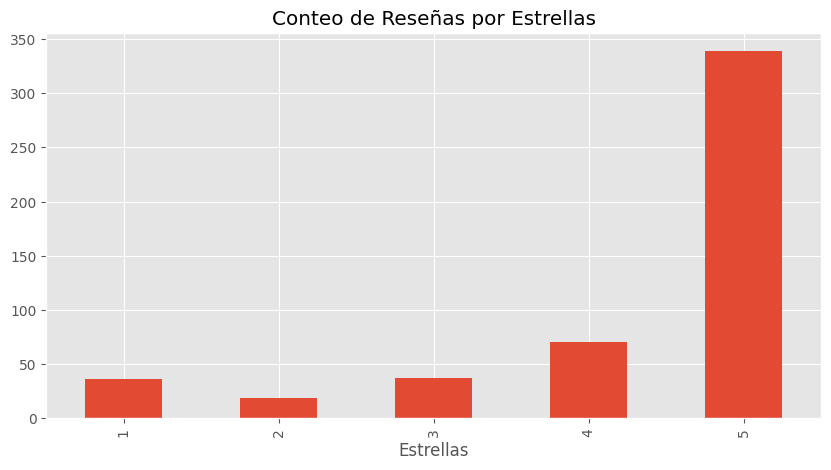

In [44]:
# Crear un gráfico de barras para mostrar el conteo de reseñas por puntaje (Score
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Conteo de Reseñas por Estrellas',
          figsize=(10, 5))
ax.set_xlabel('Estrellas')
plt.show()

Vemos que es un dataset muy desbalanceado, ya que la mayoria de reseñas son de 5 estrellas.

# Step 1. VADER Scoring de Sentimiento 

Usaremos el `SentimentIntensityAnalyzer` de NLTK para obtener las puntuaciones de negación/neutro/positiva del texto.

- Esto utiliza un enfoque de "bag of words":
    1. Se eliminan las palabras vacías (stop words).
    2. Cada palabra se puntúa y se combina para obtener una puntuación total.
    3. La parte negativa de este modelo es que no recoge relaciones contextuales, solo analiza las palabras individualmente.

In [45]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\iagzg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [46]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm


sia = SentimentIntensityAnalyzer()

In [47]:
#Ejemplos de  uso
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [48]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [49]:
#Cogemos un ejemplo random del dataset
ejemplo = df['Text'][50]
print(ejemplo)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [50]:
sia.polarity_scores(ejemplo)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

El análisis sugiere que el texto tiene un tono principalmente neutral (78%), pero con un componente significativo de negatividad (22%) y sin positividad. El puntaje compuesto negativo indica que el sentimiento general del texto tiende a ser negativo. Por tanto el análisis en este ejemplo funciona correctamente ya que es un comentario negativo.

In [51]:
# Ejecutar el polarity score en todo el dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 500/500 [00:00<00:00, 2259.54it/s]


In [52]:
#Creamos el Dataframe con los scores y lo 'mergeamos' con el Dataframe original
tablon = pd.DataFrame(res).T
tablon = tablon.reset_index().rename(columns={'index': 'Id'})
tablon = tablon.merge(df, how='left')

In [53]:
# Ahora tenemos el score de sentimiento
tablon.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plotear resultados de VADER

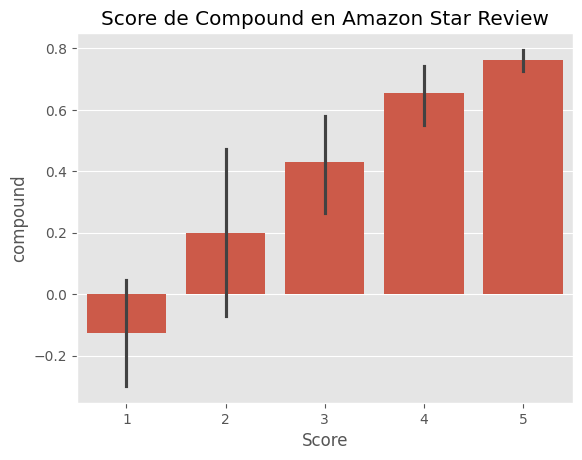

In [54]:
ax = sns.barplot(data=tablon, x='Score', y='compound')
ax.set_title('Score de Compound en Amazon Star Review')
plt.show()

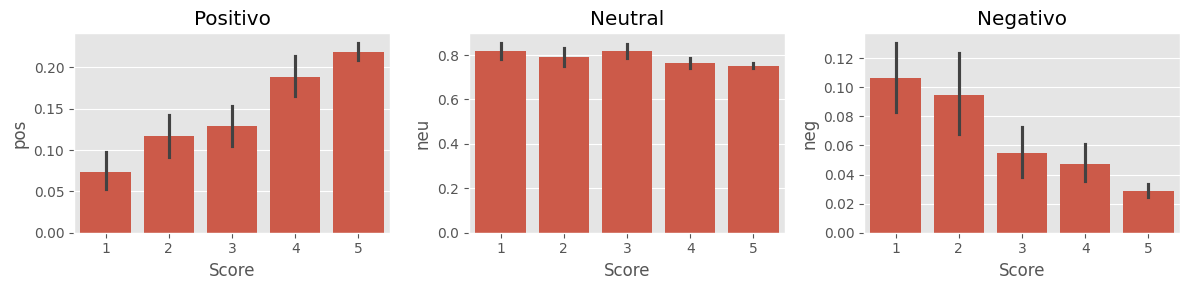

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=tablon, x='Score', y='pos', ax=axs[0])
sns.barplot(data=tablon, x='Score', y='neu', ax=axs[1])
sns.barplot(data=tablon, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positivo')
axs[1].set_title('Neutral')
axs[2].set_title('Negativo')
plt.tight_layout()
plt.show()

Tanto el score de compound, como los de positivo neutral y negativo se ajustan muy bien a lo que el análisis de sentimiento ha predicho. Puesto que a mayor score, mas compound, mas positivo y menos negativo.

# Step 3. Modelo pretrained de RoBERTa

- Utiliza un modelo entrenado en un gran corpus de datos.
- El modelo Transformer tiene en cuenta las palabras, pero también el contexto relacionado con otras palabras.
- El modelo esta preentrenado en un dataset de mas de 200.000 comentarios recogidos de twitter.

In [56]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [57]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Verifica si tienes soporte para GPU (si aplicable)


2.4.1+cpu
False


In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# Carga el tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Carga el modelo y fuerza el uso de CPU
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


c:\Users\iagzg\miniconda3\envs\nltk_env\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [59]:
# Resultado de VADER en el ejemplo
print(ejemplo)
sia.polarity_scores(ejemplo)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [60]:
# Modelo de Roberta 
encoded_text = tokenizer(ejemplo, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687466), 'roberta_pos': np.float32(0.0029573692)}


El modelo predice que efectivamente es un comentario con sentimiento negativo.

In [61]:
#Creamos una funcion para que la apliquemos en un for
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [62]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

 17%|█▋        | 84/500 [00:05<00:21, 19.40it/s]

Broke for id 83


 38%|███▊      | 189/500 [00:11<00:16, 19.37it/s]

Broke for id 187


100%|██████████| 500/500 [00:31<00:00, 15.86it/s]


In [63]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [64]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3: Ejemplos:

- Reseñas positivas de 1 estrella y negativas de 5 estrellas
- Veamos algunos ejemplos donde la puntuación del modelo y la puntuación de la reseña difieren más.

In [65]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [66]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [67]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [68]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

Es una reseña positiva pero a la vez con sentimiento negativo.

# Step 4: Pipeline
- Manera facil y rapida para analizar sentimientos:

In [69]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [70]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [71]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]